In [182]:
%matplotlib inline
import networkx as nx

#Week 11 Tutorial + Homework

Contents:

1. [Finding hubs](#Finding-hubs)
2. [Centrality distributions](#Centrality-distributions)
3. [Testing robustness](#Testing-robustness)


## 1. Finding hubs

Often when looking at a network, we want to find the most "important" nodes, for some definition of important. The most basic measure of centrality is the *degree*, or number of links attached to a node.

Let's look at the Enron executive email graph:

Name: 
Type: Graph
Number of nodes: 143
Number of edges: 623
Average degree:   8.7133
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


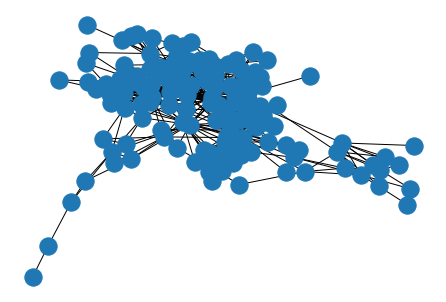

In [183]:
# You may need to replace the path if your setup is different.
G = nx.read_edgelist('ia-enron-only.edges')
print(nx.info(G))
nx.draw(G)

We're going to make use of Python's built-in `max` function in order to find the node with the highest degree. 

### Aside: the `max` function

First, let us recall what the `max` function does. At its most basic, the `max` function returns the "greatest" item in a sequence:

In [134]:
max([1,2,3,4,5])

But the "greatest" item is not always obvious:

In [135]:
max(['apple', 'grape', 'carrot'])

Why is `grape` greater than the other options? Because the default sort for strings is lexicographical (basically alphabetical) order. If we don't want this default ordering, we can specify a *key* function, which tells Python how to compare the items:

In [136]:
max(['apple', 'grape', 'carrot'], key=len)

Now `carrot` is the greatest element, because we're comparing the items by their length.

### Finding the node with max degree

We can apply the `max` function to get the maximum node according to some criterion. In our case, we want to compare the nodes by their degree:

In [184]:
highest_degree_node = max(G.nodes, key=G.degree)
highest_degree_node

'105'

In [185]:
G.degree(highest_degree_node)

42

So we know that node `'105'` has 42 edges connected to it. Let's look at that calculation a little closer:

```python
max(G.nodes, key=G.degree)
```

We're telling the `max` function that we want the item from `G.nodes` that gives us the highest value when passed to the *key* function `G.degree`.

This construction works because `G.degree` is a function. Some other measures of centrality such as betweenness generate all of the nodes' centrality values at once and return a `dict`. In this case, we need an extra step:

In [186]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
highest_betweenness_node

'105'

In [187]:
betweenness[highest_betweenness_node]

0.19400604344556296

Note that the following will throw an error:

In [141]:
# max(G.nodes, key=betweenness)

This is because we need to provide a function to the `key` argument, but `betweenness` is a dict. To get around this, we use the dict's `get` method.

## 2. Centrality distributions

We've found the most central node in the network, but often we want to summarize information about the centrality of all nodes. For example, in addition to the maxmimum degree, we often want the mean and median degree in a network.

The first step in summarizing this information is to get a sequence of all of the centrality values in the graph. We don't care about the node names anymore, we just want a sequence of numbers. We can start with the example of degree:

In [188]:
degree_sequence = [G.degree(n) for n in G.nodes]

To get the mean and median of this sequence, we can use Python's built-in `statistics` module:

In [143]:
import statistics

print('Mean degree:', statistics.mean(degree_sequence))
print('Median degree:', statistics.median(degree_sequence))

For other measures of centrality, which are calculated for the whole network at once and return a dict, we can use the dict's `.values()`.

In [189]:
betweenness = nx.centrality.betweenness_centrality(G)
betweenness_sequence = list(betweenness.values())

print('Mean betweenness:', statistics.mean(betweenness_sequence))
print('Median betweenness:', statistics.median(betweenness_sequence))

Mean betweenness: 0.013950388838012454
Median betweenness: 0.0037492834763570323


### Plotting the distribution

We can graphically represent the sequence of centrality values by using a *histogram*. In its basic form, a histogram plots the degree values on the x-axis, and the number of nodes having that degree on the y-axis. To do this counting, we can make use of Python's `collections.Counter`.

In [190]:
from collections import Counter

degree_counts = Counter(degree_sequence)
degree_counts

Counter({30: 1,
         2: 16,
         17: 5,
         12: 5,
         13: 3,
         16: 5,
         10: 9,
         11: 10,
         18: 3,
         20: 1,
         15: 3,
         19: 2,
         7: 9,
         14: 6,
         9: 16,
         42: 1,
         8: 6,
         5: 8,
         6: 7,
         1: 6,
         4: 11,
         23: 1,
         3: 9})

The `Counter` object returned is like a dict, pairing the item counted with the number of times it showed up in the sequence.

On this basic histogram plot, we want an x-value for every integer between the minimum and maximum degree in the sequence, inclusive. Note that `degree_counts.keys()` gives us every distinct value seen in the degree sequence. Also note that we need the +1 in the `range` below because we want to include the right endpoint.

In [191]:
min_degree, max_degree = min(degree_counts.keys()), max(degree_counts.keys())

plot_x = list(range(min_degree, max_degree + 1))

Our y-values are then the number of times we counted each x-value in the degree sequence. We can make use of the `.get` method with a default value in order to count 0 for degree values that don't show up in the sequence. For example, notice that 32 does not show up in `degree_counts` above, so `degree_counts.get(32, 0)` will give us 0.

In [192]:
plot_y = [degree_counts.get(x, 0) for x in plot_x]

To do the plotting, we use Matplotlib's `pyplot` module.

In [148]:
import matplotlib.pyplot as plt

plt.bar(plot_x, plot_y)

### Histogram binning

When there are more x-values than you can comfortably display, or when your centrality measure is not discrete, as in the case of betweenness centrality, we can make use of histogram "binning." This just defines a sequence of disjoint intervals called *bins*, and counts the number of values that fall into each such bin. In the simplest of cases, we can just tell Pyplot's `hist` function how many bins we want and it will do the binning for us.

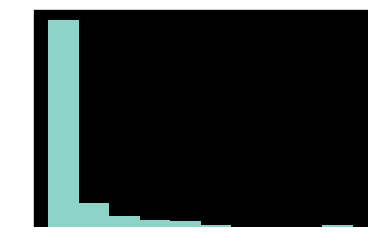

In [193]:
counts, bins, patches = plt.hist(betweenness_sequence, bins=10)

We can investigate the returned `bins` and `counts` if we want:

In [194]:
bins

array([0.        , 0.0194006 , 0.03880121, 0.05820181, 0.07760242,
       0.09700302, 0.11640363, 0.13580423, 0.15520483, 0.17460544,
       0.19400604])

In [195]:
counts

array([115.,  13.,   6.,   4.,   3.,   1.,   0.,   0.,   0.,   1.])

From these, we can see that there are 115 values between 0 and 0.0194006, 13 values between 0.194006 and 0.3880121, etc.

#Exercise 1

As seen in the previous homework - the socfb-Northwestern25 network is a snapshot of Northwestern University’s Facebook network. The nodes are anonymous users and the links are friend relationships. 



In [196]:
# You may need to replace the path if your setup is different.
northwestern_fb_file_path = 'socfb-Northwestern25.edgelist'
J = nx.read_edgelist(northwestern_fb_file_path)

Which of the following shapes best describes the degree distribution in
this network?

**a.** *Uniform: node degrees are evenly distributed between the minimum and maximum.*

**b.** *Normal: most node degrees are near the mean, dropping o↵ rapidly in both directions.*

**c.** *Right-tailed: most node degrees are relatively small compared to
the range of degrees.* 

**d.** *Left-tailed: most node degrees are relatively large compared to the
range of degrees.*

**Put your answer as a comment in the next cell, and justify your answer by producing a histogram visualization**

Minimum Degree Value: 1 Maximum Degree Value: 2105


"\nNote: The higher degree values (like 2105, the maximum value) doesn't show up on the graph until you make the bin size at least 500 or so.\n\nThe shape of this graph's degree distrobution is right tailed, so most people have few friends on facebook. \n\n"

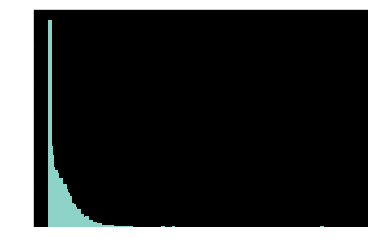

In [197]:
# Get dictionary of frequencies and values
nwFBDegrees = [J.degree(n) for n in J] # Gets degrees of all nodes
nwKeyValues = Counter(nwFBDegrees) # Creates dictionary of node degrees and the frequency of that degree
# print(nwKeyValues)

# X-axis
minX, maxX = min(nwKeyValues.keys()), max(nwKeyValues.keys()) # X axis range from 0 to highest degree value
print('Minimum Degree Value:', minX, 'Maximum Degree Value:', maxX)
x_axis = list(range(minX, maxX))

# Y-axis
y_axis = [nwKeyValues.get(x, 0) for x in x_axis] # Values from 0 to maximum degree frequency, shows y-axis range
# print(y_axis)

# Bar graph with bin size of 25
plt.bar(x_axis, y_axis, 25)


'''
Note: The higher degree values (like 2105, the maximum value) doesn't show up on the graph until you make the bin size at least 500 or so.

The shape of this graph's degree distrobution is right tailed, so most people have few friends on facebook. 

'''

## 3. Testing robustness

Another way to think about the relative "importance" of nodes in a network is to measure how much it would damage the network structure if particular nodes were to be removed. In real life, node removal might be a person moving away and out of a social network, someone changing jobs and being removed from an email network, internet routers being attacked/overloaded and going down, etc.

Broadly, we consider two types of network damage: random failure and targeted attack. In a random failure, nodes are chosen randomly for removal. In a targeted attack, we will remove nodes based on some criterion, for example, removing nodes in decreasing order of their degree centrality.

### Connected components

In order to measure "damage," we will measure the size of the network's largest connected component, sometimes called *core*. First we observe that `nx.connected_components` is a generator that provides the connected components one at a time, starting with the largest.

In [198]:
list(nx.connected_components(G))

[{'1',
  '10',
  '100',
  '101',
  '102',
  '103',
  '104',
  '105',
  '106',
  '107',
  '108',
  '109',
  '11',
  '110',
  '111',
  '112',
  '113',
  '114',
  '115',
  '116',
  '117',
  '118',
  '119',
  '12',
  '120',
  '121',
  '122',
  '123',
  '124',
  '125',
  '126',
  '127',
  '128',
  '129',
  '13',
  '130',
  '131',
  '132',
  '133',
  '134',
  '135',
  '136',
  '137',
  '138',
  '139',
  '14',
  '140',
  '141',
  '142',
  '143',
  '15',
  '16',
  '17',
  '18',
  '19',
  '2',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '3',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '4',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '5',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '6',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '7',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '

Since we often only want the core, or largest connected component, we can use the `next` function to get just the first item from the generator. Each component is provided as a set of node names:

In [199]:
core = next(nx.connected_components(G))
core

{'1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '141',
 '142',
 '143',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',

So the `len` of this set gives us the number of nodes in this component:

In [200]:
len(core)

143

If we want all of the connected components, we can get a list of them:

In [201]:
components = list(nx.connected_components(G))

the length of this list is the number of connected components:

In [202]:
len(components)

1

### Random failure

Whenever we're going to engage in a distructive process, we want to make a copy of the network graph to attack so that we can easily get back to the original state:

In [203]:
C = G.copy()

To simulate random failure, we randomly choose some node names and remove them from the graph. We can use `random.sample` to remove more than one node at at time. Note that we need to make a `list` of node names from which to randomly sample:

In [205]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)

The full simulation is going to work like this, beginning from a fresh copy of the network:

1. Measure size of the network core as compared to the original network size
2. Select M nodes at random and remove them
3. Repeat until there are less than M nodes

We'll determine M from how many steps we want this process to take. Around 25 steps should be good, so:

In [206]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5

We can then use `range` to generate a sequence of the total number of nodes removed at each step:

In [207]:
num_nodes_removed = range(0, G.number_of_nodes(), M)

#Exercise 2

Write code which randomly removes nodes until the number of nodes in the network is less than M 

You need to make a graph of this random failure where the Y axis is the porportion of nodes in the core, and the X-axis is the number of nodes removed. 

Number of nodes in C: 143


'\nThe graph is always right tailed, as expected, as the proportion of nodes removed increases, the lower the proportion of nodes is in the core \n'

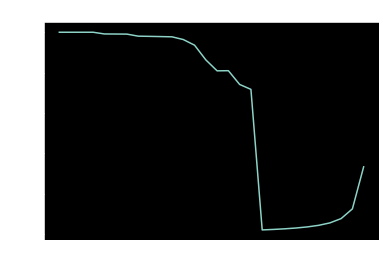

In [212]:
N = G.number_of_nodes()
C = G.copy()

plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')

# M = 5, so this should take 25 steps

print('Number of nodes in C:', C.number_of_nodes())

proportions = {}

#your code here
while len(C.nodes) > 5:
    # Make list of nodes to remove
    removables = random.sample(list(C.nodes), 5)
    # Remove nodes
    C.remove_nodes_from(removables)
    # Number of nodes removed (x-axis)
    removed = (N - C.number_of_nodes())
    # print('Overall proportion of removed nodes:', removed)
    # Proportion of nodes in the core (y-axis)
    core = len(next(nx.connected_components(C))) / (C.number_of_nodes())
    # print('Proportion of nodes in the core:', core)
    # Add values to dictionary
    proportions[removed] = core

# print(proportions)

# X-Axis
xaxis = list(proportions.keys()) 
# print('Keys:', proportions.keys())

# Y-Axis
# miny, maxy = min(proportions.values()), max(proportions.values()) 
# print(miny, maxx)
# yaxis = [proportions.get(x, 0) for x in xaxis]
yaxis = list(proportions.values())
# print('Values:', proportions.values())


plt.plot(xaxis, yaxis)


'''
The graph is always right tailed, as expected, as the proportion of nodes removed increases, the lower the proportion of nodes is in the core 
'''


#### Targeted attack

Simulating a targeted attack is similar, except that instead of choosing randomly, we will select the M most central nodes at each step. To accomplish this we want something like the `max` function used earler to get the most central node, but able to get the top M nodes. We can use Python's `sorted` function in a similar way to `max` to first sort the nodes by centrality in descending, or reverse, order. Once sorted by degree, we take the first M nodes in the list:

In [209]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
top_degree_nodes

['105', '17', '95', '48', '132']

#Exercise 3

Write code which targets and removes the top M nodes, it should repeat this process until the number of nodes in the network is less than M

You need to make a graph of this targeted attack where the Y axis is the porportion of nodes in the core, and the X-axis is the number of nodes removed. 

['105', '17', '95', '48', '132']


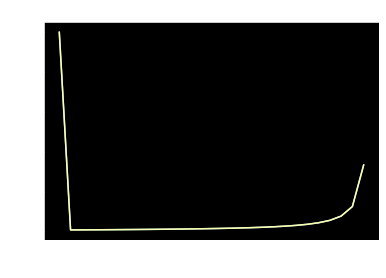

In [213]:
N = G.number_of_nodes()
number_of_steps = 25

# Note - the '//' operator divides and returns the integer value of the quotient. 
# It dumps the digits after the decimal.
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
# your code here

# Sort nodes by degree
nodesDesc = sorted(C.nodes, key=C.degree, reverse=True)
print(nodesDesc[:M])

# Dictionary of values
props = {}

while len(C.nodes) > M:
    # Remove x number of high degree nodes
    removables = nodesDesc[:M]
    # Remove nodes from C
    C.remove_nodes_from(removables)
    # Update nodesDesc to rmeove the first M nodes
    nodesDesc = nodesDesc[M:]
    # Number of nodes removed (x-axis)
    removed = (N - C.number_of_nodes())
    # Proportion of core nodes (y-axis)
    core = len(next(nx.connected_components(C))) / (C.number_of_nodes())
    # print('Proportion of removed nodes:', removed)
    # print('Proportion of core nodes:', core)
    # Add proportions to dictionary
    props[removed] = core

# X-Axis
xaxis2 = list(props.keys())

# Y-Axis
yaxis2 = list(props.values())


plt.plot(xaxis2, yaxis2)


plt.plot(xaxis2, yaxis2)






#Exercise 4

Plot both the random failure and targeted attack curves on the same plot. 

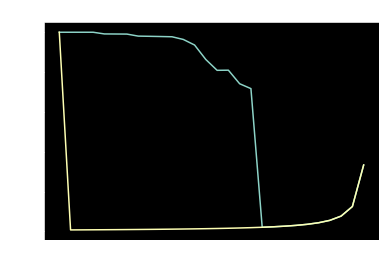

In [214]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')

#your code here

plt.plot(xaxis, yaxis)
plt.plot(xaxis2, yaxis2)


#Exercise 5

What do you notice about the difference between these two types of attack on the network? 
Justify your answer - what do you think is/are the reason(s) for the difference?

The random failure network takes much longer to fail than the targeted network. This is because the random failures are likely not hubs, which means that a lot of paths between nodes  will still be intact. Notably, removing important nodes or hubs with high overall centrality sort of eliminates a lot of necessary paths for traversing between nodes.

The targeted network's core goes down almost immediately because we are removing the highest degree nodes at each iteration. Again, doing so removes a ton of necessary paths for traversal within the core component.